In [1]:
import sys
import os.path as op
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.mixture import GaussianMixture

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

sys.path.append(op.join(op.expanduser("~"), "code"))
from general.array import array_operations as aop
from general.basic.config import get_plot_defaults, set_rcparams
import general.basic.helper_funcs as hf
import general.basic.str_methods as strm

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)

# Load and format data

## Load data

In [64]:
# Import the data
ssheet_dir = "/Users/dschonhaut/Box/projects/leads_tau_clustering/data/ssheets"
indat = pd.read_csv(
    op.join(ssheet_dir, "baseline_FTP_72fsrois_data_suvr-infcblg_379eoad_89cn.csv")
)

print(f"indat: {indat.shape}")

indat: (33696, 9)


In [66]:
def calc_vogel_rois(roi_dat):
    """Return a dataframe with volume-weighted means for each Vogel ROI"""
    vogel_rois = {
        "l_mtl": ["L_amygdala", "L_hippocampus", "L_entorhinal"],
        "r_mtl": ["R_amygdala", "R_hippocampus", "R_entorhinal"],
        "l_temporal": [
            "L_fusiform",
            "L_inferiortemporal",
            "L_middletemporal",
            "L_parahippocampal",
            "L_superiortemporal",
            "L_transversetemporal",
        ],
        "r_temporal": [
            "R_fusiform",
            "R_inferiortemporal",
            "R_middletemporal",
            "R_parahippocampal",
            "R_superiortemporal",
            "R_transversetemporal",
        ],
        "l_parietal": [
            "L_inferiorparietal",
            "L_isthmuscingulate",
            "L_postcentral",
            "L_posteriorcingulate",
            "L_precuneus",
            "L_superiorparietal",
            "L_supramarginal",
        ],
        "r_parietal": [
            "R_inferiorparietal",
            "R_isthmuscingulate",
            "R_postcentral",
            "R_posteriorcingulate",
            "R_precuneus",
            "R_superiorparietal",
            "R_supramarginal",
        ],
        "l_occipital": [
            "L_cuneus",
            "L_lateraloccipital",
            "L_lingual",
            "L_pericalcarine",
        ],
        "r_occipital": [
            "R_cuneus",
            "R_lateraloccipital",
            "R_lingual",
            "R_pericalcarine",
        ],
        "l_frontal": [
            "L_caudalanteriorcingulate",
            "L_caudalmiddlefrontal",
            "L_insula",
            "L_lateralorbitofrontal",
            "L_medialorbitofrontal",
            "L_parsopercularis",
            "L_parsorbitalis",
            "L_parstriangularis",
            "L_precentral",
            "L_rostralanteriorcingulate",
            "L_rostralmiddlefrontal",
            "L_superiorfrontal",
        ],
        "r_frontal": [
            "R_caudalanteriorcingulate",
            "R_caudalmiddlefrontal",
            "R_insula",
            "R_lateralorbitofrontal",
            "R_medialorbitofrontal",
            "R_parsopercularis",
            "R_parsorbitalis",
            "R_parstriangularis",
            "R_precentral",
            "R_rostralanteriorcingulate",
            "R_rostralmiddlefrontal",
            "R_superiorfrontal",
        ],
    }
    # Make sure we're only looking at one scan at a time
    assert len(roi_dat.drop_duplicates(["subj", "dx", "ftp_date"])) == 1

    # Get the subject ID and cohort assignment.
    subj, dx = roi_dat.iloc[0][["subj", "dx"]]

    # Put the columns we need in a dict so we can query them quickly.
    roi_dat = roi_dat.set_index(["roi"])[["suvr", "vol"]].to_dict()

    output = []
    for roi, subrois in vogel_rois.items():
        subroi_means = [roi_dat["suvr"][subroi] for subroi in subrois]
        subroi_vols = [roi_dat["vol"][subroi] for subroi in subrois]
        roi_mean = np.average(subroi_means, weights=subroi_vols)
        output.append([subj, dx, roi, roi_mean])

    output = pd.DataFrame(output, columns=["subj", "dx", "roi", "suvr"])
    return output

In [86]:
# Calculate the volume-weighted means for each Vogel ROI
data = []
for idx, dat in indat.groupby("subj"):
    data.append(calc_vogel_rois(dat))
data = pd.concat(data).reset_index(drop=True)

# Reorder the ROIs.
rois = [
    "l_mtl",
    "l_temporal",
    "l_parietal",
    "l_occipital",
    "l_frontal",
    "r_mtl",
    "r_temporal",
    "r_parietal",
    "r_occipital",
    "r_frontal",
]
data["roi"] = data["roi"].astype(pd.CategoricalDtype(categories=rois, ordered=True))

# Resort the dataframe.
data = data.sort_values(["subj", "roi"]).reset_index(drop=True)

print(f"data: {data.shape}")
display(data.drop_duplicates("subj").groupby("dx").size())

data: (4680, 4)


dx
CN       89
EOAD    379
dtype: int64

# Z-score ROI SUVRs

## A- control approach

In [91]:
# Z-score ROI SUVRs against the A- controls

# Calculate the mean and stdev SUVR for each ROI in the CN group.
cn_stats = data.query("(dx=='CN')").groupby(["roi"]).agg({"suvr": ["mean", "std"]})
cn_stats.columns = ["mean", "std"]

# Z-score the SUVRs
data["z_cn"] = data.apply(
    lambda x: (x["suvr"] - cn_stats.at[x["roi"], "mean"])
    / cn_stats.at[x["roi"], "std"],
    axis=1,
)

# Let's make sure the Z-scoring worked (i.e., the mean and stdev Z-score should be 0 and 1 in controls).
display(
    data.groupby(["dx", "roi"]).agg(
        {"subj": "count", "suvr": ["mean", "std"], "z_cn": ["mean", "std"]}
    )
)

/var/folders/lq/rtbxthxd0ld0kkzmrlfbcktc0000gp/T/ipykernel_60625/770677336.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cn_stats = data.query("(dx=='CN')").groupby(["roi"]).agg({"suvr": ["mean", "std"]})
/var/folders/lq/rtbxthxd0ld0kkzmrlfbcktc0000gp/T/ipykernel_60625/770677336.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(data.groupby(["dx", "roi"]).agg({"subj": "count", "suvr": ["mean", "std"], "z_cn": ["mean", "std"]}))


subj      suvr                    z_cn          
                 count      mean       std          mean       std
dx   roi                                                          
CN   l_mtl          89  1.147086  0.105486 -3.742325e-16  1.000000
     l_temporal     89  1.131258  0.102495  8.028846e-16  1.000000
     l_parietal     89  1.083718  0.118819  1.995907e-17  1.000000
     l_occipital    89  1.112627  0.127315 -4.004288e-16  1.000000
     l_frontal      89  1.054900  0.065674 -1.396511e-15  1.000000
     r_mtl          89  1.149653  0.113675  4.740278e-17  1.000000
     r_temporal     89  1.131780  0.116582 -5.682096e-16  1.000000
     r_parietal     89  1.086896  0.154291  2.494883e-18  1.000000
     r_occipital    89  1.111354  0.159638 -7.484650e-17  1.000000
     r_frontal      89  1.060796  0.079416  1.044109e-15  1.000000
EOAD l_mtl         379  1.613830  0.239153  4.424709e+00  2.267151
     l_temporal    379  2.061288  0.475834  9.073872e+00  4.642493
     l_parietal    379  2.117550  0.561264  8.700930e+00  4.723710
     l_occipital   379  1.860655  0.560324  5.875420e+00  4.401094
     l_frontal     379  1.680392  0.421428  9.524227e+00  6.416978
     r_mtl         379  1.588378  0.234893  3.859471e+00  2.066358
     r_temporal    379  2.007082  0.461753  7.508046e+00  3.960755
     r_parietal    379  2.087474  0.560034  6.485013e+00  3.629729
     r_occipital   379  1.833929  0.561607  4.526330e+00  3.518005
     r_frontal     379  1.641302  0.419987  7.309733e+00  5.288476

## GMM approach

In [485]:
data["suvr"].values.reshape(-1, 1).shape

(4680, 1)

In [493]:
# Z-score ROI SUVRs by fitting 2-component Gaussian mixture models
rs = 0
n_components = 2
n_init = 100
init_params = "random_from_data"

# -------------------------------------------
roi_gmms = {}
fitted_gmms = []
for roi, data_roi in data.groupby("roi"):
    gmm = GaussianMixture(n_components=2, random_state=0).fit(
        data_roi["suvr"].values.reshape(-1, 1)
    )
    print()
    data.loc[data_roi.index, "z_gmm"] = gmm.score_samples(
        data_roi["suvr"].values.reshape(-1, 1)
    )

    # Fit GMM
    gmm = GaussianMixture(
        n_components=n_components, init_params=init_params, n_init=n_init
    )
    gmm.fit(data_roi[["suvr"]])
    roi_gmms[roi] = gmm
    idx = np.argsort(gmm.means_.ravel())
    gmm_means, gmm_stds, gmm_weights = (
        gmm.means_.ravel()[idx],
        np.sqrt(gmm.covariances_.ravel())[idx],
        gmm.weights_.ravel()[idx],
    )
    output_row = [roi]
    for i in range(n_components):
        output_row.extend([gmm_means[i], gmm_stds[i], gmm_weights[i]])
    fitted_gmms.append(output_row)
fitted_gmms = pd.DataFrame(
    fitted_gmms, columns=["roi", "mean1", "std1", "weight1", "mean2", "std2", "weight2"]
)

# Z-score SUVRs against the mean and stdev of the lower GMM component for each region
data["z_gmm"] = (
    data[["roi", "suvr"]]
    .merge(fitted_gmms[["roi", "mean1", "std1"]], how="left", on="roi")
    .apply(lambda x: (x["suvr"] - x["mean1"]) / x["std1"], axis=1)
)

/var/folders/lq/rtbxthxd0ld0kkzmrlfbcktc0000gp/T/ipykernel_60625/4064597024.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for roi, data_roi in data.groupby("roi"):












fitted_gmms: (10, 7)


In [496]:
cn_stats

,mean,std
roi,,
l_mtl,1.147086,0.105486
l_temporal,1.131258,0.102495
l_parietal,1.083718,0.118819
l_occipital,1.112627,0.127315
l_frontal,1.054900,0.065674
r_mtl,1.149653,0.113675
r_temporal,1.131780,0.116582
r_parietal,1.086896,0.154291
r_occipital,1.111354,0.159638


In [498]:
fitted_gmms[["roi", "mean1", "std1"]]

,roi,mean1,std1
0,l_mtl,1.153091,0.080183
1,l_temporal,1.132263,0.058373
2,l_parietal,1.088083,0.070828
3,l_occipital,1.131529,0.071256
4,l_frontal,1.071344,0.065693
5,r_mtl,1.157205,0.089734
6,r_temporal,1.132082,0.062808
7,r_parietal,1.079613,0.060722
8,r_occipital,1.114157,0.051633
9,r_frontal,1.073490,0.057716


## Save Z-scored data

In [506]:
# Save data
outf = op.join(
    ssheet_dir, "baseline_FTP_72fsrois_data_suvr-infcblg_379eoad_89cn-zscores.csv"
)
data.to_csv(outf, index=False)
print(f"Saved {outf}")
print(f"data: {data.shape}")

Saved /Users/dschonhaut/Box/projects/leads_tau_spread/data/ssheets/baseline_FTP_72fsrois_data_suvr-infcblg_379eoad_89cn-zscores.csv
data: (4680, 6)


# GMM simulation

## Simulate some data

Component C1
  Actual  μ = 1.05, σ = 0.1, weight = 0.20
Component C2
  Actual  μ = 1.5, σ = 0.25, weight = 0.80


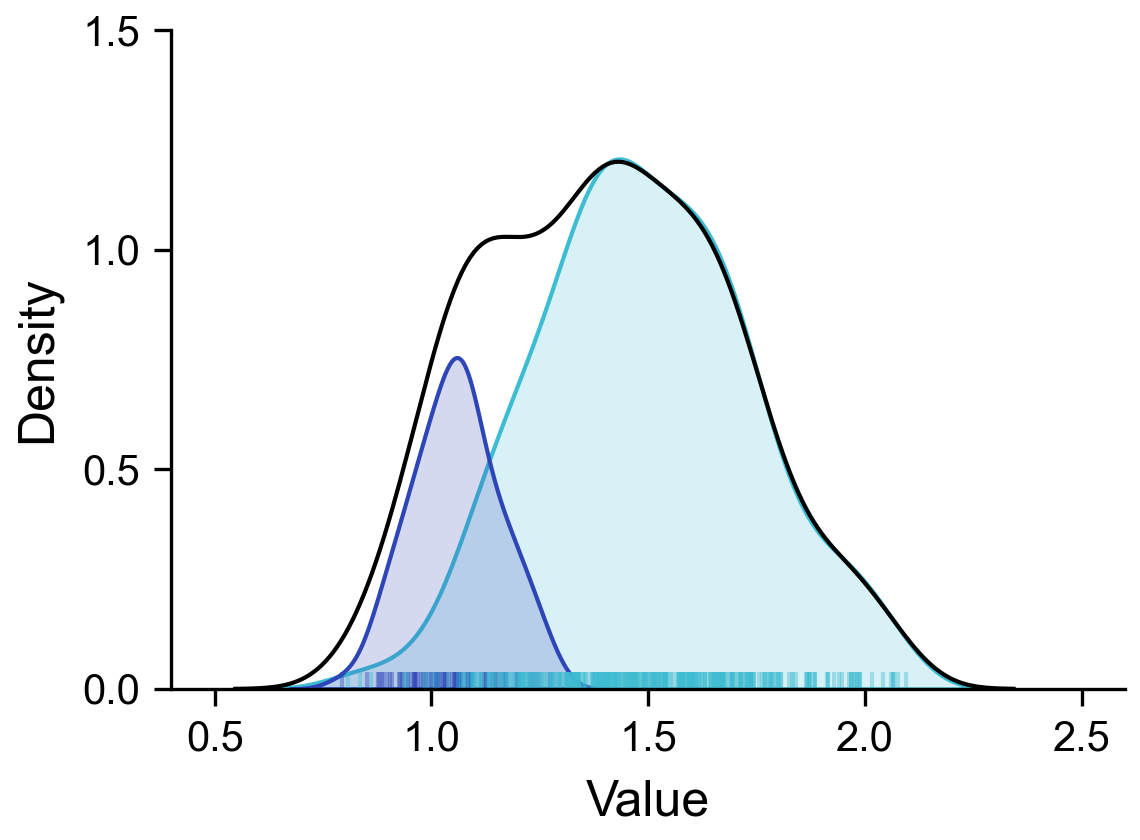

In [478]:
# Simulate data from Gaussian-distributed points
rs = 0
lower_thresh = -np.inf
simparams = {
    "C1": {"loc": 1.05, "scale": 0.1, "size": 100},
    "C2": {"loc": 1.5, "scale": 0.25, "size": 400},
}
lw = 1
pal = [co["b"], co["c"]]


# -------------------------------------------------------
# Simulate data
components = sorted(list(simparams.keys()))
n_components = len(components)
# simdat = []
# for c in components:
#     simvals = stats.norm.rvs(
#         loc=simparams[c]["loc"], scale=simparams[c]["scale"], size=1000, random_state=rs
#     )
#     simvals = simvals[simvals > lower_thresh][:simparams[c]["size"]]
#     simvals = pd.DataFrame(simvals, columns=["value"])
#     simvals.insert(0, "component", c)
#     simdat.append(simvals)
# simdat = pd.concat(simdat).reset_index(drop=True)

# Plot the data and the fitted GMM
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]
sns.kdeplot(
    data=simdat,
    x="value",
    hue="component",
    common_norm=True,
    fill=True,
    alpha=0.2,
    lw=lw,
    ax=_ax,
    legend=False,
)
sns.kdeplot(data=simdat, x="value", color="k", lw=lw, ax=_ax, legend=False)
sns.rugplot(
    data=simdat,
    x="value",
    hue="component",
    alpha=0.4,
    palette=pal,
    ax=_ax,
    legend=False,
)

_ax.set_xlim([0.4, 2.6])
_ax.set_xticks([0.5, 1, 1.5, 2, 2.5])
_ax.set_ylim([0, 1.5])
_ax.set_yticks([0, 0.5, 1, 1.5])
_ax.set_xlabel("Value")
_ax.set_ylabel("Density")

for ii, c in enumerate(components):
    print(f"Component {c}")
    print(
        f"  Actual  μ = {simparams[c]['loc']}, σ = {simparams[c]['scale']}, weight = {simparams[c]['size']/sum([simparams[c]['size'] for c in components]):.2f}"
    )

## Fit a 2-component GMM to the data using default parameters

GMM
  n_components = 2
  init_params  = kmeans
  n_init       = 1
  BIC          = 174.68

Component C1
  Actual  μ = 1.05, σ = 0.1, weight = 0.20
  GMM-Est μ = 1.19, σ = 0.18, weight = 0.49
Component C2
  Actual  μ = 1.5, σ = 0.25, weight = 0.80
  GMM-Est μ = 1.62, σ = 0.20, weight = 0.51


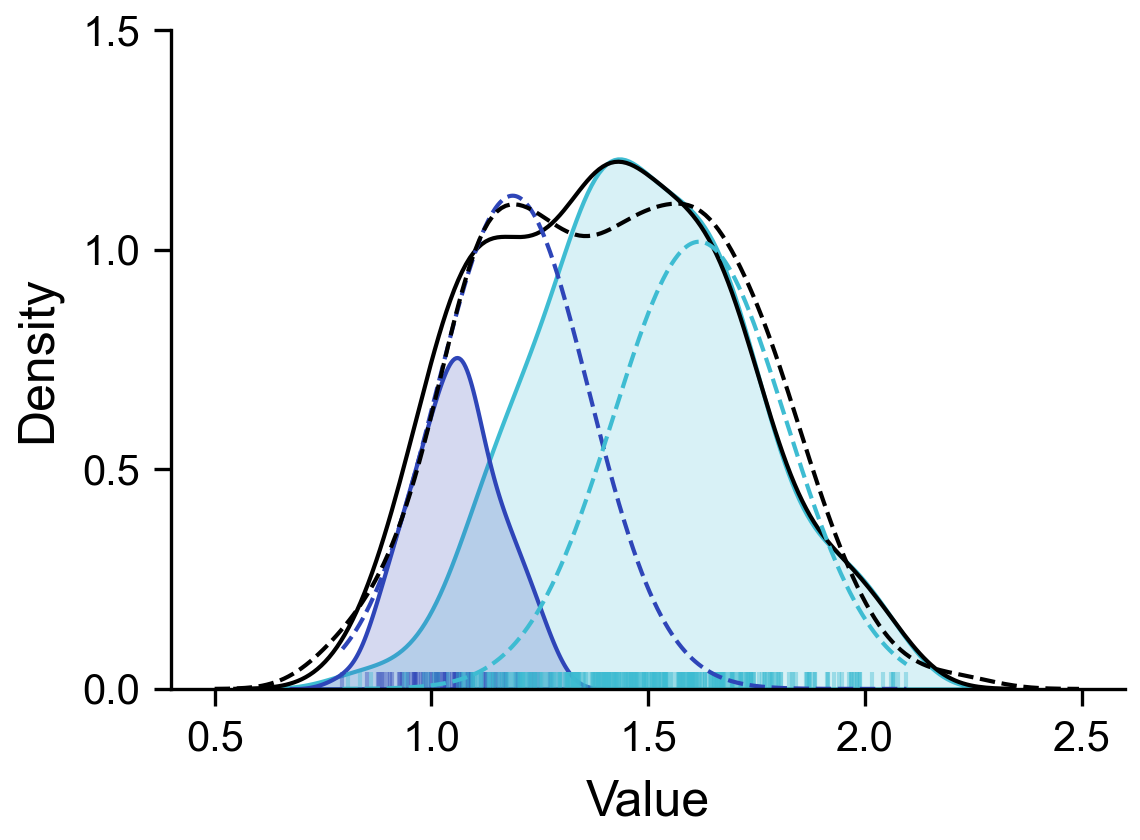

In [480]:
# Simulate data from Gaussian-distributed points
rs = 0
n_components = 2
n_init = 1
init_params = "kmeans"
lower_thresh = -np.inf
simparams = {
    "C1": {"loc": 1.05, "scale": 0.1, "size": 100},
    "C2": {"loc": 1.5, "scale": 0.25, "size": 400},
}
lw = 1
pal = [co["b"], co["c"]]


# -------------------------------------------------------
# Simulate data
components = sorted(list(simparams.keys()))
# simdat = []
# for c in components:
#     simvals = stats.norm.rvs(
#         loc=simparams[c]["loc"], scale=simparams[c]["scale"], size=1000, random_state=rs
#     )
#     simvals = simvals[simvals > lower_thresh][:simparams[c]["size"]]
#     simvals = pd.DataFrame(simvals, columns=["value"])
#     simvals.insert(0, "component", c)
#     simdat.append(simvals)
# simdat = pd.concat(simdat).reset_index(drop=True)

# Fit GMM
gmm = GaussianMixture(n_components=n_components, init_params=init_params, n_init=n_init)
gmm.fit(simdat[["value"]])
idx = np.argsort(gmm.means_.ravel())
gmm_means, gmm_stds, gmm_weights = (
    gmm.means_.ravel()[idx],
    np.sqrt(gmm.covariances_.ravel())[idx],
    gmm.weights_.ravel()[idx],
)

# Plot the data and the fitted GMM
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]
sns.kdeplot(
    data=simdat,
    x="value",
    hue="component",
    common_norm=True,
    fill=True,
    alpha=0.2,
    lw=lw,
    ax=_ax,
    legend=False,
)
sns.kdeplot(data=simdat, x="value", color="k", lw=lw, ax=_ax, legend=False)
sns.rugplot(
    data=simdat,
    x="value",
    hue="component",
    alpha=0.4,
    palette=pal,
    ax=_ax,
    legend=False,
)

# Add Gaussians showing the mean, stdev, and weight of each fitted component
x = np.linspace(simdat["value"].min(), simdat["value"].max(), 1000)
for i in range(n_components):
    y = gmm_weights[i] * stats.norm.pdf(x, gmm_means[i], gmm_stds[i])
    _ax.plot(x, y, color=pal[i], ls="--", lw=lw)

# Plot the combined predicted distribution
x = pd.Series(gmm.sample(1000)[0].flatten())
sns.kdeplot(data=x, color="k", ls="--", lw=lw, ax=_ax, legend=False)

_ax.set_xlim([0.4, 2.6])
_ax.set_xticks([0.5, 1, 1.5, 2, 2.5])
_ax.set_ylim([0, 1.5])
_ax.set_yticks([0, 0.5, 1, 1.5])
_ax.set_xlabel("Value")
_ax.set_ylabel("Density")

# fig.suptitle("2-component GMM fit to simulated data")
print("GMM")
print(f"  n_components = {n_components}")
print(f"  init_params  = {init_params}")
print(f"  n_init       = {n_init}")
print("  BIC          = {:.2f}".format(gmm.bic(simdat[["value"]])), end="\n" * 2)
for ii, c in enumerate(components):
    print(f"Component {c}")
    print(
        f"  Actual  μ = {simparams[c]['loc']}, σ = {simparams[c]['scale']}, weight = {simparams[c]['size']/sum([simparams[c]['size'] for c in components]):.2f}"
    )
    print(
        f"  GMM-Est μ = {gmm_means[ii]:.2f}, σ = {gmm_stds[ii]:.2f}, weight = {gmm_weights[ii]:.2f}"
    )

## Are we getting stuck in a local-minimum?
Let's try:
- Using random initialization of component centers, rather than k-means clustering
- Testing multiple initializations and choosing the best fitting one

GMM
  n_components = 2
  init_params  = random_from_data
  n_init       = 1
  BIC          = 173.25

Component C1
  Actual  μ = 1.05, σ = 0.1, weight = 0.20
  GMM-Est μ = 1.17, σ = 0.17, weight = 0.46
Component C2
  Actual  μ = 1.5, σ = 0.25, weight = 0.80
  GMM-Est μ = 1.60, σ = 0.20, weight = 0.54


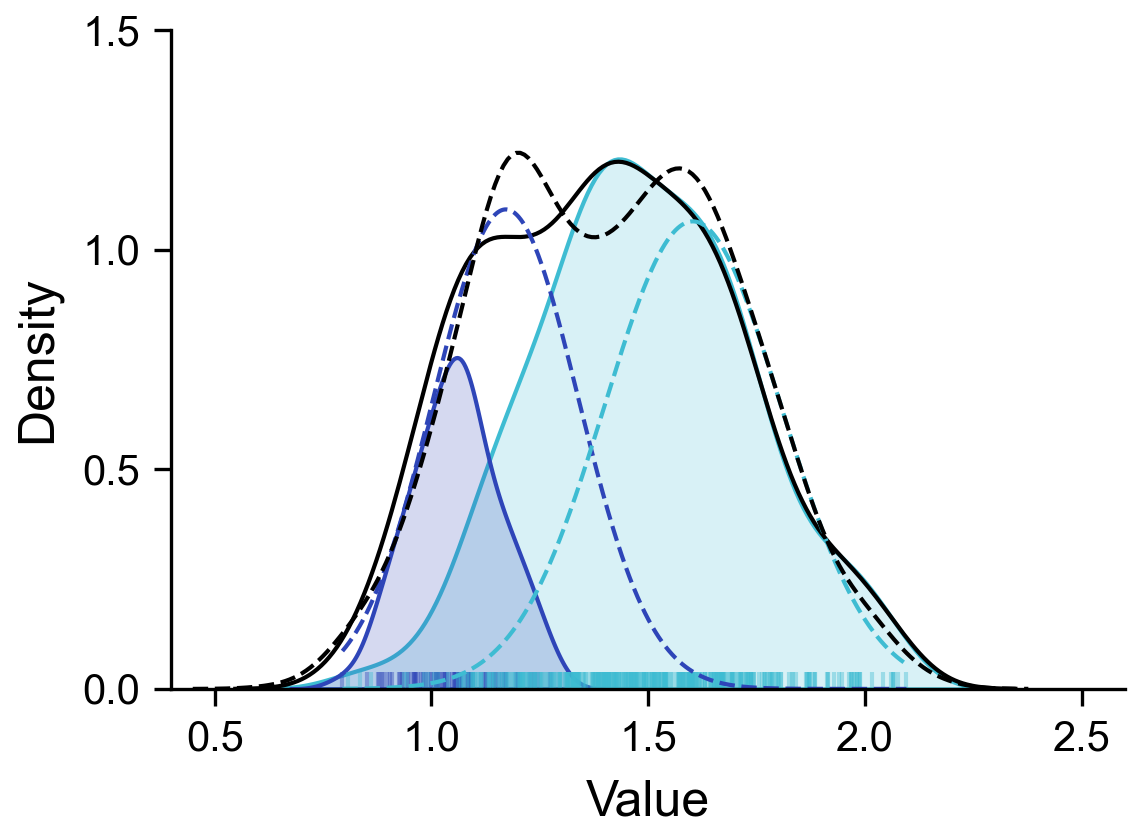

In [482]:
# Simulate data from Gaussian-distributed points
rs = 0
n_components = 2
n_init = 1
init_params = "random_from_data"
lower_thresh = -np.inf
simparams = {
    "C1": {"loc": 1.05, "scale": 0.1, "size": 100},
    "C2": {"loc": 1.5, "scale": 0.25, "size": 400},
}
lw = 1
pal = [co["b"], co["c"]]


# -------------------------------------------------------
# Simulate data
components = sorted(list(simparams.keys()))
n_components = len(components)
# simdat = []
# for c in components:
#     simvals = stats.norm.rvs(
#         loc=simparams[c]["loc"], scale=simparams[c]["scale"], size=1000, random_state=rs
#     )
#     simvals = simvals[simvals > lower_thresh][:simparams[c]["size"]]
#     simvals = pd.DataFrame(simvals, columns=["value"])
#     simvals.insert(0, "component", c)
#     simdat.append(simvals)
# simdat = pd.concat(simdat).reset_index(drop=True)

# Fit GMM
gmm = GaussianMixture(n_components=n_components, init_params=init_params, n_init=n_init)
gmm.fit(simdat[["value"]])
idx = np.argsort(gmm.means_.ravel())
gmm_means, gmm_stds, gmm_weights = (
    gmm.means_.ravel()[idx],
    np.sqrt(gmm.covariances_.ravel())[idx],
    gmm.weights_.ravel()[idx],
)

# Plot the data and the fitted GMM
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]
sns.kdeplot(
    data=simdat,
    x="value",
    hue="component",
    common_norm=True,
    fill=True,
    alpha=0.2,
    lw=lw,
    ax=_ax,
    legend=False,
)
sns.kdeplot(data=simdat, x="value", color="k", lw=lw, ax=_ax, legend=False)
sns.rugplot(
    data=simdat,
    x="value",
    hue="component",
    alpha=0.4,
    palette=pal,
    ax=_ax,
    legend=False,
)

# Add Gaussians showing the mean, stdev, and weight of each fitted component
x = np.linspace(simdat["value"].min(), simdat["value"].max(), 1000)
for i in range(n_components):
    y = gmm_weights[i] * stats.norm.pdf(x, gmm_means[i], gmm_stds[i])
    _ax.plot(x, y, color=pal[i], ls="--", lw=lw)

# Plot the combined predicted distribution
x = pd.Series(gmm.sample(1000)[0].flatten())
sns.kdeplot(data=x, color="k", ls="--", lw=lw, ax=_ax, legend=False)

_ax.set_xlim([0.4, 2.6])
_ax.set_xticks([0.5, 1, 1.5, 2, 2.5])
_ax.set_ylim([0, 1.5])
_ax.set_yticks([0, 0.5, 1, 1.5])
_ax.set_xlabel("Value")
_ax.set_ylabel("Density")

# fig.suptitle("2-component GMM fit to simulated data")
print("GMM")
print(f"  n_components = {n_components}")
print(f"  init_params  = {init_params}")
print(f"  n_init       = {n_init}")
print("  BIC          = {:.2f}".format(gmm.bic(simdat[["value"]])), end="\n" * 2)
for ii, c in enumerate(components):
    print(f"Component {c}")
    print(
        f"  Actual  μ = {simparams[c]['loc']}, σ = {simparams[c]['scale']}, weight = {simparams[c]['size']/sum([simparams[c]['size'] for c in components]):.2f}"
    )
    print(
        f"  GMM-Est μ = {gmm_means[ii]:.2f}, σ = {gmm_stds[ii]:.2f}, weight = {gmm_weights[ii]:.2f}"
    )

GMM
  n_components = 2
  init_params  = random_from_data
  n_init       = 100
  BIC          = 164.58

Component C1
  Actual  μ = 1.05, σ = 0.1, weight = 0.20
  GMM-Est μ = 1.06, σ = 0.10, weight = 0.20
Component C2
  Actual  μ = 1.5, σ = 0.25, weight = 0.80
  GMM-Est μ = 1.49, σ = 0.25, weight = 0.80


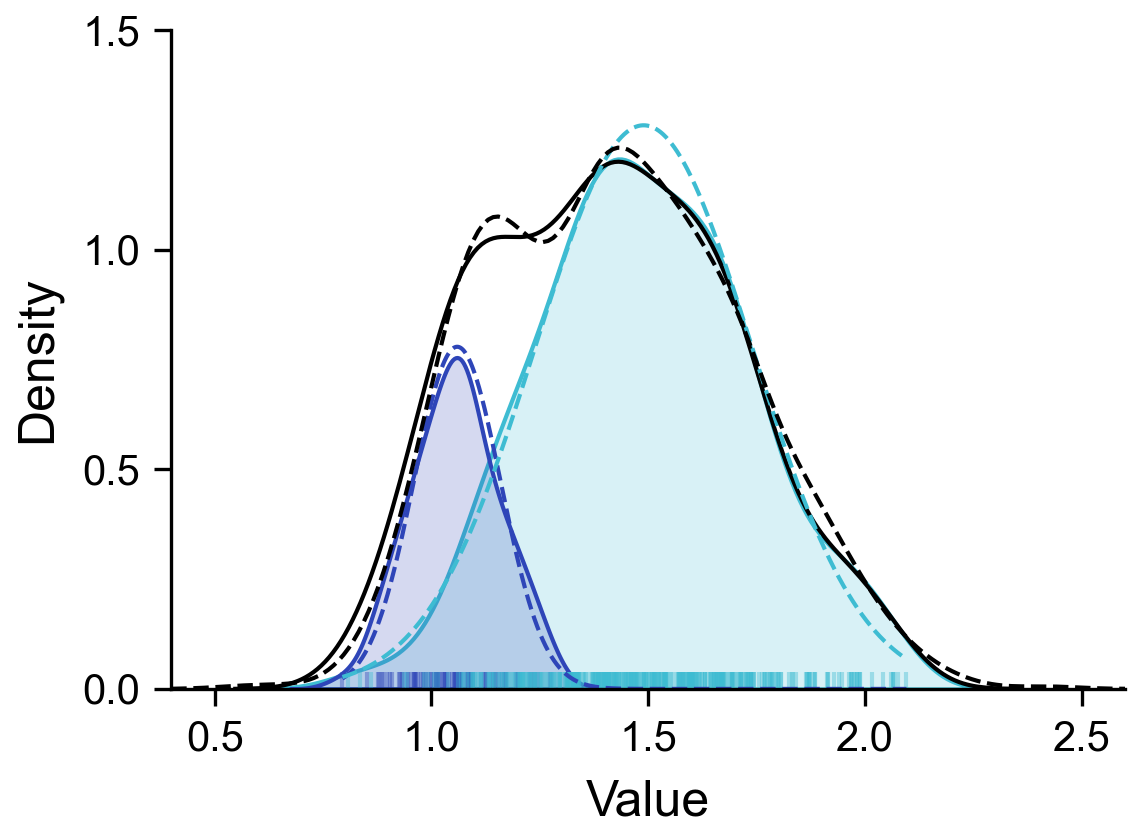

In [481]:
# Simulate data from Gaussian-distributed points
rs = 0
n_components = 2
n_init = 100
init_params = "random_from_data"
lower_thresh = -np.inf
simparams = {
    "C1": {"loc": 1.05, "scale": 0.1, "size": 100},
    "C2": {"loc": 1.5, "scale": 0.25, "size": 400},
}
lw = 1
pal = [co["b"], co["c"]]


# -------------------------------------------------------
# Simulate data
components = sorted(list(simparams.keys()))
n_components = len(components)
# simdat = []
# for c in components:
#     simvals = stats.norm.rvs(
#         loc=simparams[c]["loc"], scale=simparams[c]["scale"], size=1000, random_state=rs
#     )
#     simvals = simvals[simvals > lower_thresh][:simparams[c]["size"]]
#     simvals = pd.DataFrame(simvals, columns=["value"])
#     simvals.insert(0, "component", c)
#     simdat.append(simvals)
# simdat = pd.concat(simdat).reset_index(drop=True)

# Fit GMM
gmm = GaussianMixture(n_components=n_components, init_params=init_params, n_init=n_init)
gmm.fit(simdat[["value"]])
idx = np.argsort(gmm.means_.ravel())
gmm_means, gmm_stds, gmm_weights = (
    gmm.means_.ravel()[idx],
    np.sqrt(gmm.covariances_.ravel())[idx],
    gmm.weights_.ravel()[idx],
)

# Plot the data and the fitted GMM
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax = np.ravel(ax)
iax = 0
_ax = ax[iax]
sns.kdeplot(
    data=simdat,
    x="value",
    hue="component",
    common_norm=True,
    fill=True,
    alpha=0.2,
    lw=lw,
    ax=_ax,
    legend=False,
)
sns.kdeplot(data=simdat, x="value", color="k", lw=lw, ax=_ax, legend=False)
sns.rugplot(
    data=simdat,
    x="value",
    hue="component",
    alpha=0.4,
    palette=pal,
    ax=_ax,
    legend=False,
)

# Add Gaussians showing the mean, stdev, and weight of each fitted component
x = np.linspace(simdat["value"].min(), simdat["value"].max(), 1000)
for i in range(n_components):
    y = gmm_weights[i] * stats.norm.pdf(x, gmm_means[i], gmm_stds[i])
    _ax.plot(x, y, color=pal[i], ls="--", lw=lw)

# Plot the combined predicted distribution
x = pd.Series(gmm.sample(1000)[0].flatten())
sns.kdeplot(data=x, color="k", ls="--", lw=lw, ax=_ax, legend=False)

_ax.set_xlim([0.4, 2.6])
_ax.set_xticks([0.5, 1, 1.5, 2, 2.5])
_ax.set_ylim([0, 1.5])
_ax.set_yticks([0, 0.5, 1, 1.5])
_ax.set_xlabel("Value")
_ax.set_ylabel("Density")

# fig.suptitle("2-component GMM fit to simulated data")
print("GMM")
print(f"  n_components = {n_components}")
print(f"  init_params  = {init_params}")
print(f"  n_init       = {n_init}")
print("  BIC          = {:.2f}".format(gmm.bic(simdat[["value"]])), end="\n" * 2)
for ii, c in enumerate(components):
    print(f"Component {c}")
    print(
        f"  Actual  μ = {simparams[c]['loc']}, σ = {simparams[c]['scale']}, weight = {simparams[c]['size']/sum([simparams[c]['size'] for c in components]):.2f}"
    )
    print(
        f"  GMM-Est μ = {gmm_means[ii]:.2f}, σ = {gmm_stds[ii]:.2f}, weight = {gmm_weights[ii]:.2f}"
    )

# Compare Z-score methods

## Load data

In [521]:
# Load data
infile = op.join(
    ssheet_dir, "baseline_FTP_72fsrois_data_suvr-infcblg_379eoad_89cn-zscores.csv"
)
data = pd.read_csv(infile)

# Reformat ROI columns
data.rename(columns={"roi": "hemroi"}, inplace=True)
data.insert(
    2, "hem", data["hemroi"].apply(lambda x: "L" if (x.split("_")[0] == "l") else "R")
)
data.insert(3, "roi", data["hemroi"].apply(lambda x: x.split("_")[1].capitalize()))
data.loc[data["roi"] == "Mtl", "roi"] = "MTL"

# Reformat dataframe column data types
for col in ["subj", "dx", "hem", "roi", "hemroi"]:
    data[col] = data[col].astype("category")

data["dx"] = data["dx"].astype(
    pd.CategoricalDtype(categories=["CN", "EOAD"], ordered=True)
)
data["hem"] = data["hem"].astype(
    pd.CategoricalDtype(categories=["L", "R"], ordered=True)
)
data["roi"] = data["roi"].astype(
    pd.CategoricalDtype(
        categories=["MTL", "Temporal", "Parietal", "Occipital", "Frontal"], ordered=True
    )
)

for col in ["suvr", "z_cn", "z_gmm"]:
    data[col] = data[col].astype(np.float32)

print(f"data: {data.shape}")

data: (4680, 8)


In [522]:
data

,subj,dx,hem,roi,hemroi,suvr,z_cn,z_gmm
0,LDS0070120,CN,L,MTL,l_mtl,1.212698,0.622001,0.743388
1,LDS0070120,CN,L,Temporal,l_temporal,1.127232,-0.039276,-0.086189
2,LDS0070120,CN,L,Parietal,l_parietal,1.074372,-0.078657,-0.193583
3,LDS0070120,CN,L,Occipital,l_occipital,1.103603,-0.070879,-0.391904
4,LDS0070120,CN,L,Frontal,l_frontal,1.037903,-0.258800,-0.509054
...,...,...,...,...,...,...,...,...
4675,LDS9410679,EOAD,R,MTL,r_mtl,1.992033,7.410432,9.303380
4676,LDS9410679,EOAD,R,Temporal,r_temporal,2.566414,12.305806,22.836714
4677,LDS9410679,EOAD,R,Parietal,r_parietal,2.083823,6.461352,16.537754
4678,LDS9410679,EOAD,R,Occipital,r_occipital,1.883089,4.834282,14.892353


In [525]:
data.query("(dx=='EOAD')")

,subj,dx,hem,roi,hemroi,suvr,z_cn,z_gmm
10,LDS0070166,EOAD,L,MTL,l_mtl,1.856240,6.722736,8.769327
11,LDS0070166,EOAD,L,Temporal,l_temporal,2.856721,16.834543,29.541929
12,LDS0070166,EOAD,L,Parietal,l_parietal,3.012157,16.230116,27.165529
13,LDS0070166,EOAD,L,Occipital,l_occipital,2.957153,14.487913,25.620544
14,LDS0070166,EOAD,L,Frontal,l_frontal,2.398487,20.458483,20.202158
...,...,...,...,...,...,...,...,...
4675,LDS9410679,EOAD,R,MTL,r_mtl,1.992033,7.410432,9.303380
4676,LDS9410679,EOAD,R,Temporal,r_temporal,2.566414,12.305806,22.836714
4677,LDS9410679,EOAD,R,Parietal,r_parietal,2.083823,6.461352,16.537754
4678,LDS9410679,EOAD,R,Occipital,r_occipital,1.883089,4.834282,14.892353


In [543]:
data["suvr"].max()

3.929218

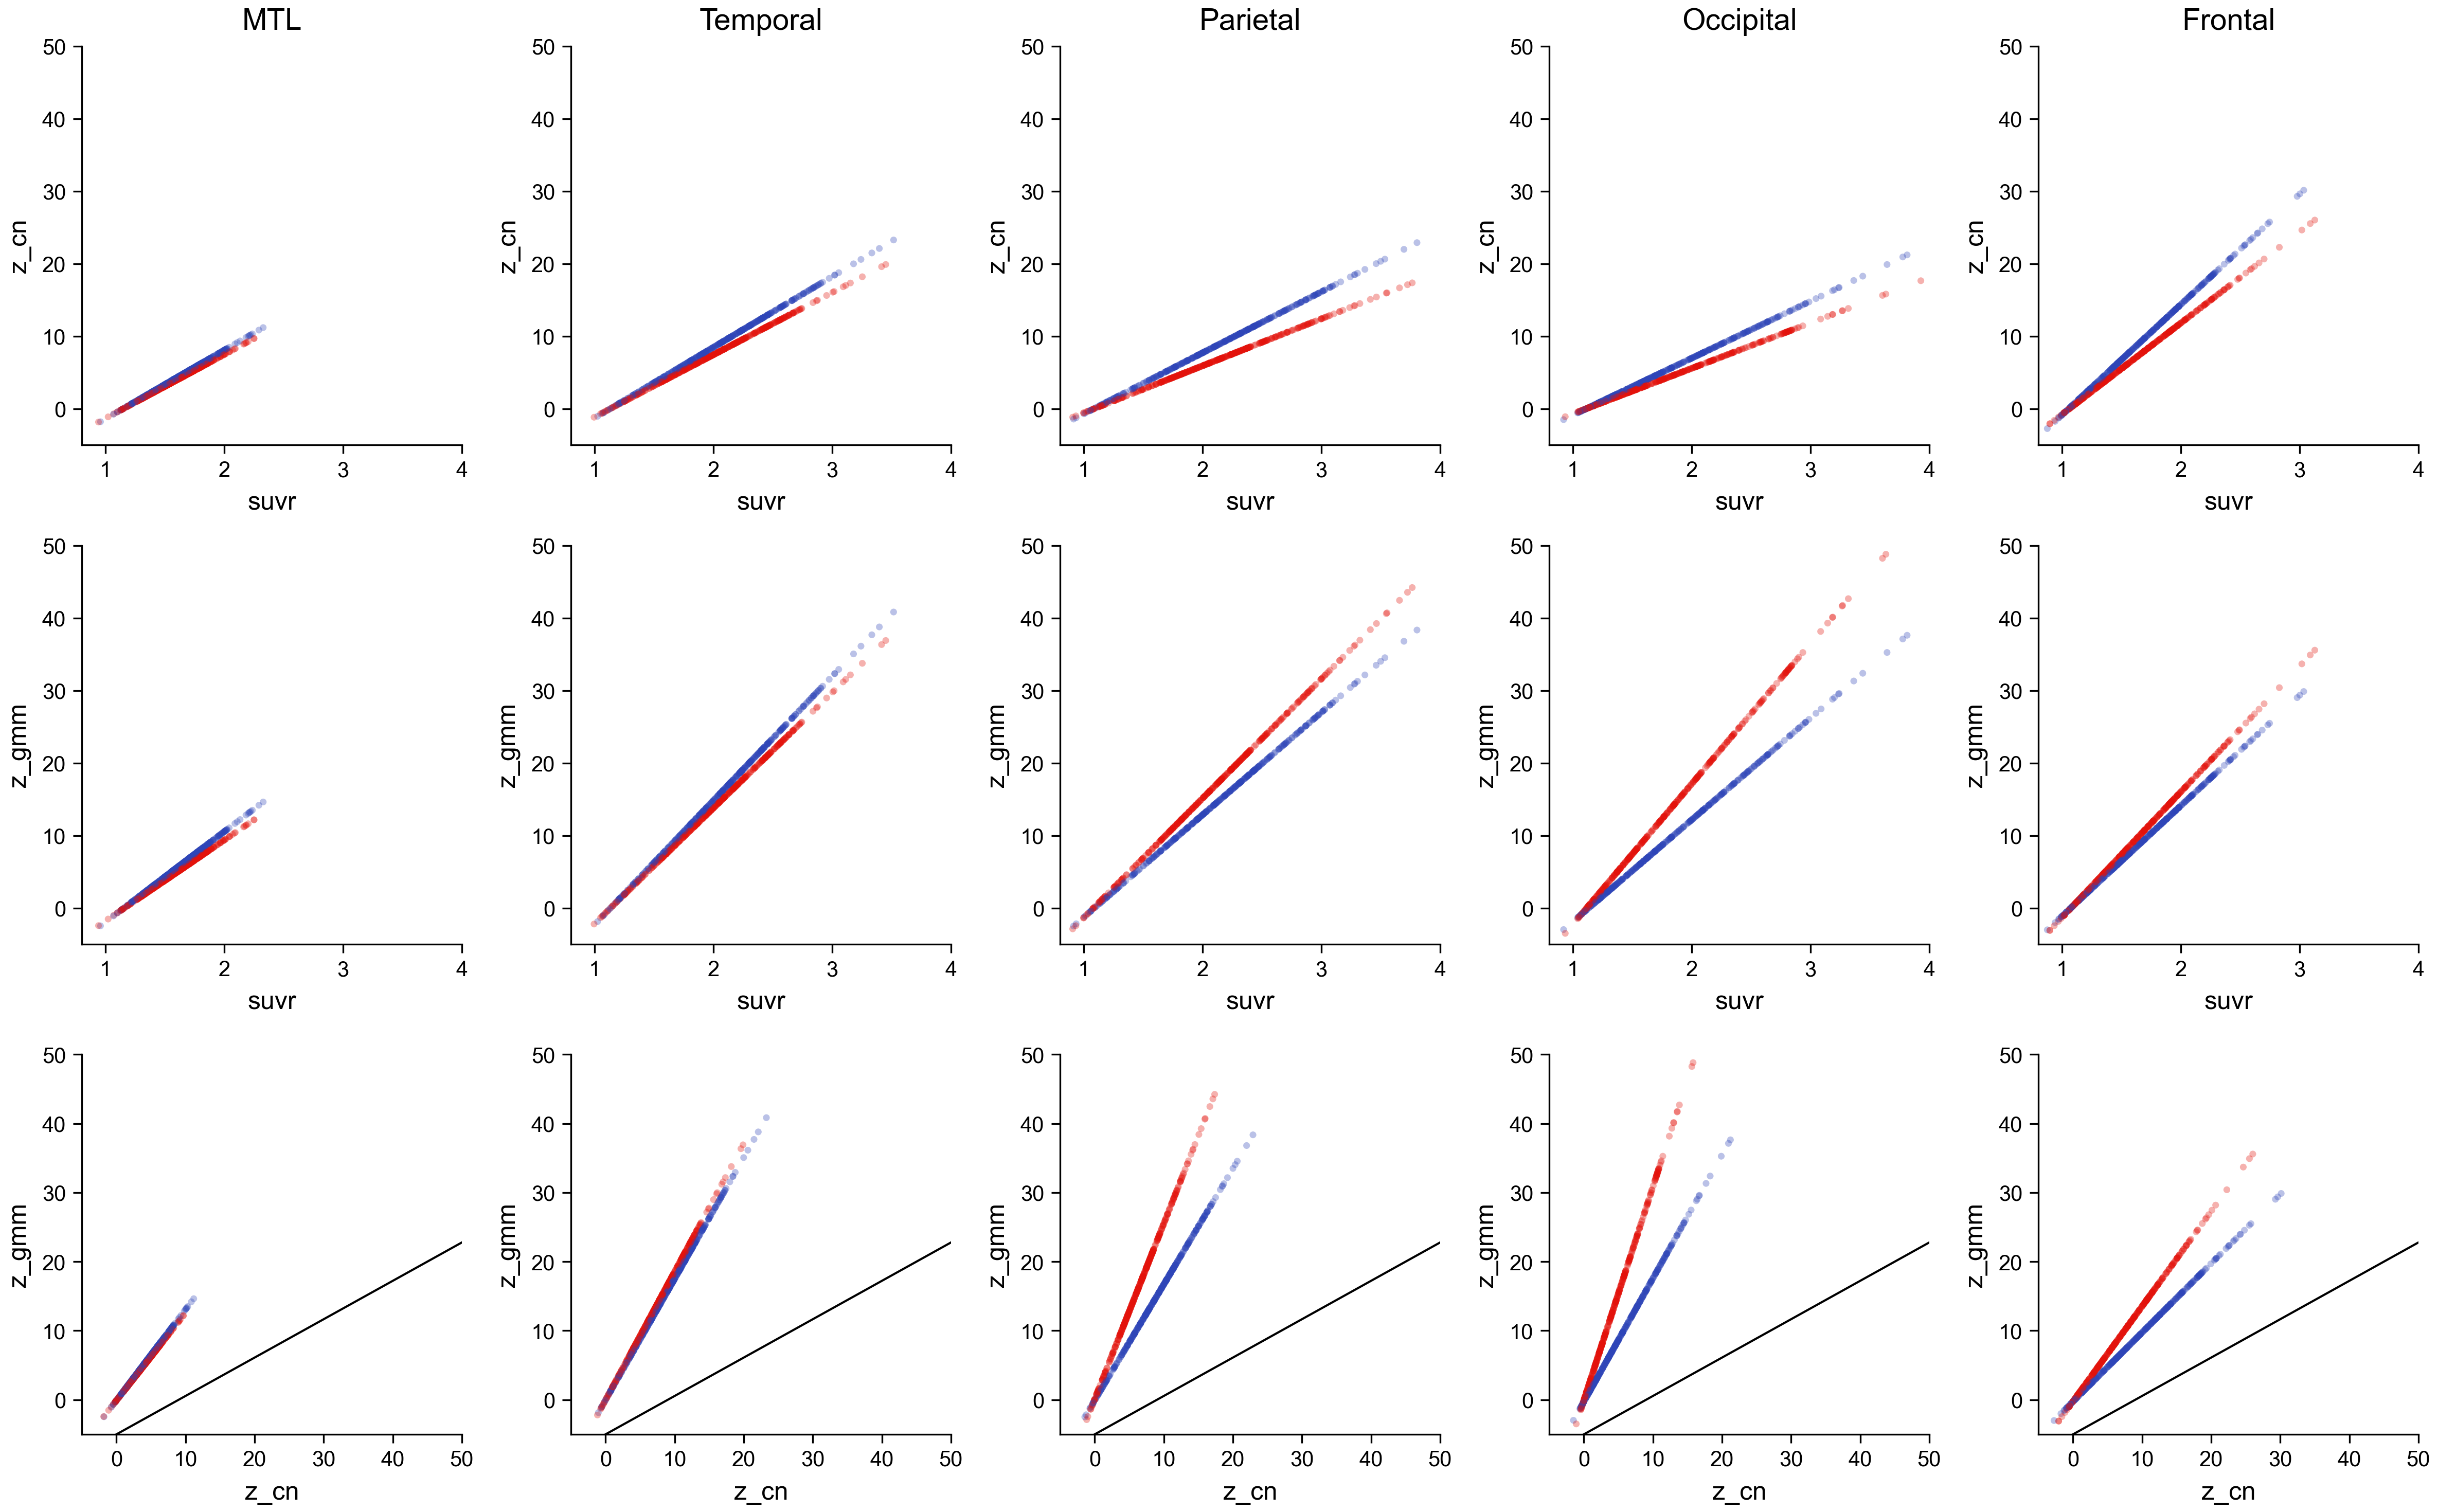

In [551]:
rois = ["MTL", "Temporal", "Parietal", "Occipital", "Frontal"]
lim = [-5, 50]
ticks = np.arange(0, 51, 10)
pal = [co["b"], co["r"]]

# -----------------------------------------------
plt.close("all")
fig, ax = plt.subplots(3, 5, figsize=(16, 10))
ax = np.ravel(ax)

col_pairs = [("suvr", "z_cn"), ("suvr", "z_gmm"), ("z_cn", "z_gmm")]
iRow = 0
for xcol, ycol in col_pairs:
    for iRoi, roi in enumerate(rois):
        iax = (5 * iRow) + iRoi
        _ax = ax[iax]

        # Plot the data
        sns.scatterplot(
            data=data.query("(dx=='EOAD') & (roi=='{}')".format(roi)),
            x=xcol,
            y=ycol,
            hue="hem",
            alpha=0.33,
            lw=0,
            s=10,
            palette=pal,
            legend=False,
            ax=_ax,
        )

        # Format plot
        if iax >= 10:
            # Plot the y=x line
            _ax.plot(np.linspace(lim[0], lim[1], 100), color="k", lw=lw, zorder=0)
            _ax.set_aspect("equal")
            _ax.set_xlim(lim)
            _ax.set_xticks(ticks)
            _ax.set_ylim(lim)
            _ax.set_yticks(ticks)
        else:
            _ax.set_xlim([0.8, 4])
            _ax.set_xticks([1, 2, 3, 4])
            _ax.set_ylim(lim)
            _ax.set_yticks(ticks)
        _ax.set_xlabel(xcol)
        _ax.set_ylabel(ycol)
        if iax < 5:
            _ax.set_title(roi)
    iRow += 1

fig.tight_layout()

In [552]:
cn_stats

,mean,std
roi,,
l_mtl,1.147086,0.105486
l_temporal,1.131258,0.102495
l_parietal,1.083718,0.118819
l_occipital,1.112627,0.127315
l_frontal,1.054900,0.065674
r_mtl,1.149653,0.113675
r_temporal,1.131780,0.116582
r_parietal,1.086896,0.154291
r_occipital,1.111354,0.159638


In [76]:
cn_stats = data_cn.groupby(["roi"]).agg({"suvr": ["mean", "std"]})
cn_stats.columns = ["mean", "std"]
cn_stats

,mean,std
roi,,
l_frontal,1.054900,0.065674
l_mtl,1.147086,0.105486
l_occipital,1.112627,0.127315
l_parietal,1.083718,0.118819
l_temporal,1.131258,0.102495
r_frontal,1.060796,0.079416
r_mtl,1.149653,0.113675
r_occipital,1.111354,0.159638
r_parietal,1.086896,0.154291


In [25]:
keep_cols = ["subj", "dx"]

,subj,visit,dx,ftp_date,parc,roi,roi_full,suvr,vol
0,LDS0070120,1,CN,2019-06-20,hem_fsroi,L_amygdala,L_amygdala,1.117458,1818
1,LDS0070166,1,EOAD,2019-08-21,hem_fsroi,L_amygdala,L_amygdala,1.933520,1159
2,LDS0070174,1,EOAD,2019-09-11,hem_fsroi,L_amygdala,L_amygdala,1.328686,1564
3,LDS0070176,1,CN,2019-09-13,hem_fsroi,L_amygdala,L_amygdala,1.091453,1569
4,LDS0070199,1,EOAD,2019-10-15,hem_fsroi,L_amygdala,L_amygdala,1.727129,1115


In [10]:
# Calculate aggregated ROIs.


for roi, subrois in vogel_rois.items():
    print("{}: {}".format(roi, np.all([subroi in data["roi"].unique() for subroi in subrois])))
    data.groupby("subj").size()np.average()

l_mtl: True
r_mtl: True
l_temporal: True
r_temporal: True
l_parietal: True
r_parietal: True
l_occipital: True
r_occipital: True
l_frontal: True
r_frontal: True


In [5]:
data.query("(dx=='CN')")

,subj,visit,dx,ftp_date,parc,roi,roi_full,suvr,vol
0,LDS0070120,1,CN,2019-06-20,hem_fsroi,L_amygdala,L_amygdala,1.117458,1818
3,LDS0070176,1,CN,2019-09-13,hem_fsroi,L_amygdala,L_amygdala,1.091453,1569
6,LDS0070253,1,CN,2020-01-14,hem_fsroi,L_amygdala,L_amygdala,1.171324,1601
27,LDS0100113,1,CN,2019-11-08,hem_fsroi,L_amygdala,L_amygdala,1.210929,1809
28,LDS0100131,1,CN,2019-09-24,hem_fsroi,L_amygdala,L_amygdala,1.260802,1471
...,...,...,...,...,...,...,...,...,...
33674,LDS9410049,1,CN,2019-02-13,hem_fsroi,R_transversetemporal,R_transversetemporal,0.906689,768
33675,LDS9410060,1,CN,2019-03-26,hem_fsroi,R_transversetemporal,R_transversetemporal,1.025048,1081
33676,LDS9410066,1,CN,2019-03-27,hem_fsroi,R_transversetemporal,R_transversetemporal,1.009587,712
33679,LDS9410152,1,CN,2019-09-30,hem_fsroi,R_transversetemporal,R_transversetemporal,1.092847,941
